In [1]:
:extension DerivingVia TypeFamilies DerivingStrategies GeneralizedNewtypeDeriving FlexibleContexts FlexibleInstances OverloadedStrings

import Prelude hiding ((*), (+))
import Diagrams.Prelude
import Control.Monad ((>=>))
import Data.Bifunctor (second, first)
import Data.Tuple (swap)
import Data.String (IsString)
import Data.List (partition, singleton)
import Data.Maybe (fromMaybe)
import IHaskell.Display.Diagrams
import Diagrams.Backend.Cairo (B)
import Data.Tree (Tree(Node), Forest, rootLabel, subForest, drawForest)
import Data.Semiring

### Type definitions

In [2]:
newtype Location = Location { name :: String } deriving newtype (Eq, Show, IsString)

data BellPair = Location :~: Location

instance Show BellPair where
    show (l1 :~: l2) = name l1 <> "," <> name l2
instance Eq BellPair where
    l1 :~: l2 == l1' :~: l2' = (l1 , l2) == (l1', l2') || (l2, l1) == (l1', l2') 

class Semigroup a => ParallelSemigroup a where
    (<||>) :: a -> a -> a

class (ParallelSemigroup a) => Quantum a where
    tryCreateBellPairFrom :: BellPair -> [BellPair] -> a
    dropWithProbability :: Double -> a

### Main policy definitions

In [3]:
data Policy 
    = Swap Location (Location, Location)
    | Transmit Location (Location, Location)
    | Distill (Location, Location)
    | Sequence Policy Policy
    | Parallel Policy Policy
    | Create Location deriving stock (Show)
    
instance Semigroup Policy where
    (<>) = Sequence
    
instance ParallelSemigroup Policy where
    (<||>) = Parallel

In [5]:
meaning :: (Quantum a) => Policy -> a
meaning (Swap l (l1, l2)) = tryCreateBellPairFrom (l1 :~: l2) [l :~: l1, l :~: l2]
meaning (Transmit l (l1, l2)) = tryCreateBellPairFrom (l1 :~: l2) [l :~: l]
meaning (Create l) = tryCreateBellPairFrom (l :~: l) []
meaning (Distill (l1, l2)) = tryCreateBellPairFrom (l1 :~: l2) [l1 :~: l2, l1 :~: l2] <> dropWithProbability 0.5
meaning (Sequence p q) = meaning p <> meaning q
meaning (Parallel p q) = meaning p <||> meaning q

### History of Bell pairs

In [6]:
newtype History = History { getForest :: Forest BellPair } deriving newtype (Show, Semigroup, Monoid) 

In [7]:
findTreeRoot :: BellPair -> History -> Maybe (Tree BellPair, History)
findTreeRoot p (History ts) =
    case partition ((== p) . rootLabel) ts of
        (t:ts, ts') -> Just (t, History (ts <> ts'))
        _ -> Nothing

findTreeRoots :: [BellPair] -> History -> Maybe (Forest BellPair, History)
findTreeRoots [] h = Just ([], h)
findTreeRoots (p : ps) h = findTreeRoot p h >>= \(t, h) ->
    findTreeRoots ps h >>= \(ts, h) -> return (t : ts, h)
    
findSubHistory :: [BellPair] -> History -> Maybe (History, History)
findSubHistory ps h = first History <$> findTreeRoots ps h

findSubHistory' :: [BellPair] -> History -> (Maybe History, History)
findSubHistory' ps h = maybe (Nothing, h) (first return) $ findSubHistory ps h

In [8]:
data HistoryQuantum = HistoryQuantum 
    { requiredRoots :: [BellPair]
    , execute :: History -> [History] 
    }
        
executePartial :: HistoryQuantum -> History -> ([History], History)
executePartial hq h = 
    case findSubHistory (requiredRoots hq) h of
        Nothing -> ([History[]], h)
        Just (hInput, hRest) -> (execute hq hInput, hRest)

In [9]:
instance Semigroup HistoryQuantum where
    hq <> hq' = HistoryQuantum 
        { requiredRoots = requiredRoots hq
        , execute = execute hq >=> execute hq'
        }
    
instance ParallelSemigroup HistoryQuantum where
    hq <||> hq' = HistoryQuantum
        { requiredRoots = requiredRoots hq <> requiredRoots hq'
        , execute = \h -> 
            let (hs, hRest) = executePartial hq h
                (hs', hRest') = executePartial hq' hRest
            in (<> hRest') <$> ((<>) <$> hs <*> hs')
        }
    
instance Quantum HistoryQuantum where
    tryCreateBellPairFrom p bp = HistoryQuantum 
        { requiredRoots = bp
        , execute = \h -> fromMaybe [h] $ findTreeRoots bp h >>= \(ts, h) -> return [h <> History [Node p ts]]
        }
    dropWithProbability _ = HistoryQuantum 
        { requiredRoots = []
        , execute = \h -> [h, History []]
        }

In [10]:
applyPolicy :: Policy -> History -> [History]
applyPolicy = execute . meaning

### Some drawing code

In [11]:
pairToDiagram bp = (text (show bp) <> rect 4 1) # fontSize (local 0.5) 

treeToDiagram t = 
    let childrenNames = [1..(length $ subForest t :: Int)]
        rootName = 0 :: Int
        subtrees = zipWith (.>>) childrenNames (map treeToDiagram $ subForest t)
      in vsep 1 [pairToDiagram (rootLabel t) # named rootName, hsep 0.5 subtrees # centerX  ] 
          # appEndo (mconcat $ map (\i -> Endo $ connectOutside (i .> rootName) rootName) childrenNames)

historyToDiagram (History ts) = hsep 0.5 (map treeToDiagram ts)

drawPolicy :: Policy -> ManuallySized (Diagram B)
drawPolicy p = withImgWidth 600 . vsep 1 . fmap historyToDiagram . applyPolicy p $ History [] 

## Examples

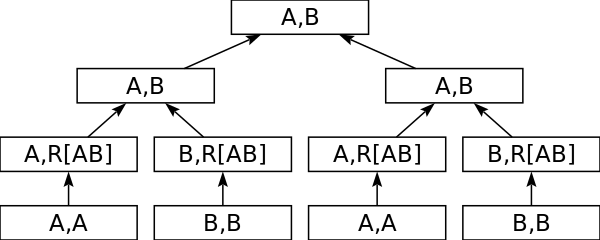

In [12]:
p = (Create "A" <||> Create "B") <> (Transmit "A" ("A", "R[AB]") <||> Transmit "B" ("B", "R[AB]")) <> Swap "R[AB]" ("A", "B")
    
drawPolicy $ (p <||> p) <> Distill ("A", "B")

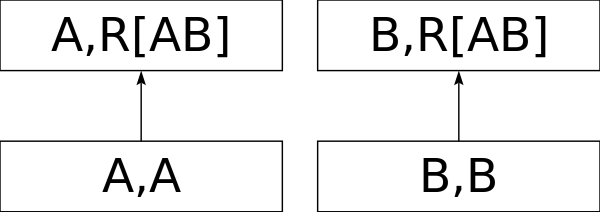

In [13]:
drawPolicy $ (Create "A" <||> Create "B") <> (Transmit "A" ("A", "R[AB]") <||> Transmit "B" ("B", "R[AB]"))

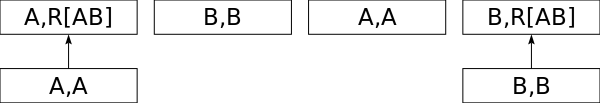

In [14]:
drawPolicy $ 
    (Create "A" <> Transmit "A" ("A", "R[AB]")) 
    <||> (Create "B" <> Transmit "A" ("A", "R[AB]")) 
    <||> (Create "A" <> Transmit "B" ("B", "R[AB]"))
    <||> (Create "B" <> Transmit "B" ("B", "R[AB]"))

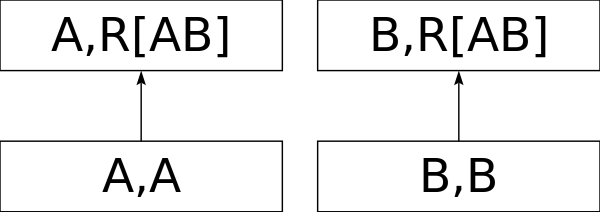

In [15]:
drawPolicy $ 
    (Create "A" <||> Create "B") <> Transmit "A" ("A", "R[AB]") <> Transmit "B" ("B", "R[AB]")

Line 5: Redundant bracket
Found:
(Transmit "B" ("B", "R[AB]") <||> Create "B")
  <> (Swap "R[AB]" ("A", "B"))
Why not:
(Transmit "B" ("B", "R[AB]") <||> Create "B")
  <> Swap "R[AB]" ("A", "B")

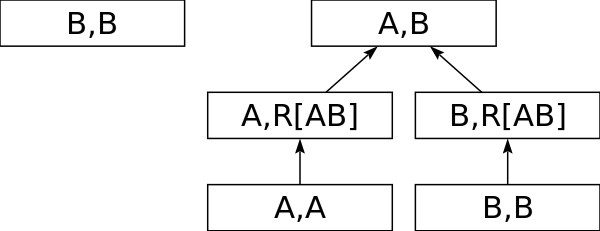

In [17]:
drawPolicy $ 
    Create "A"
    <> (Transmit "A" ("A", "R[AB]") <||> Create "B") 
    <> (Transmit "B" ("B", "R[AB]") {- <||> Identity ("A", "R[AB]") -} <||> Create "B")
    <> (Swap "R[AB]" ("A", "B") {- <||> Identity ("B", "B") -})

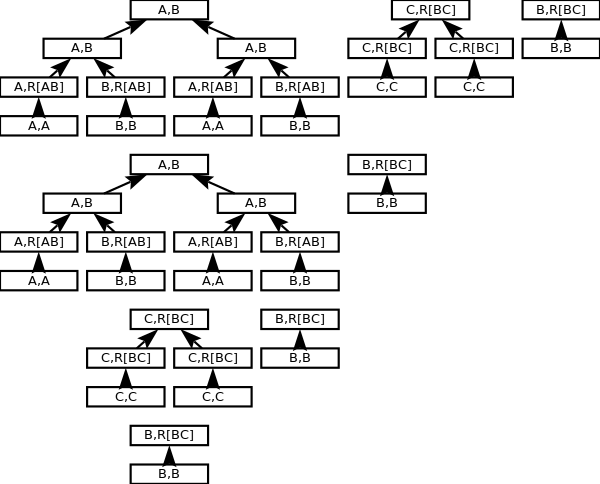

In [18]:
pAB = (Create "A" <||> Create "B") <> (Transmit "A" ("A", "R[AB]") <||> Transmit "B" ("B", "R[AB]")) <> Swap "R[AB]" ("A", "B")
pCR = ((Create "C" <> Transmit "C" ("C", "R[BC]")) <||> (Create "C" <> Transmit "C" ("C", "R[BC]"))) <> Distill ("C", "R[BC]")

drawPolicy $ ((pAB <||> pAB) <> Distill ("A", "B")) <||> (pCR <||> (Create "B" <> Transmit "B" ("B", "R[BC]")) )

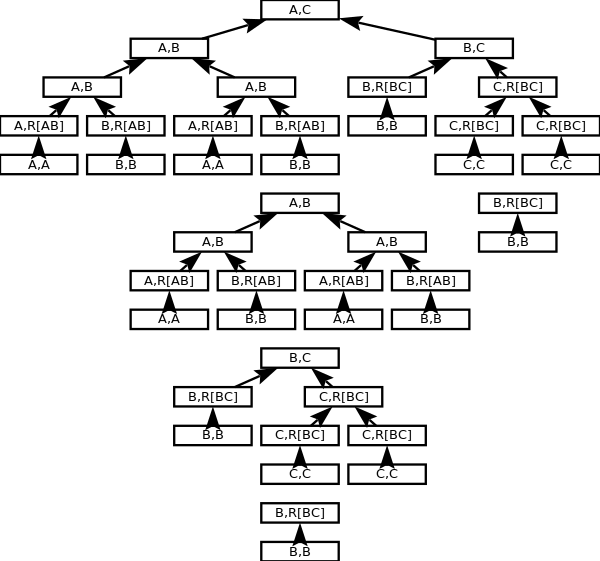

In [19]:
pAB = (Create "A" <||> Create "B") <> (Transmit "A" ("A", "R[AB]") <||> Transmit "B" ("B", "R[AB]")) <> Swap "R[AB]" ("A", "B")
pCR = ((Create "C" <> Transmit "C" ("C", "R[BC]")) <||> (Create "C" <> Transmit "C" ("C", "R[BC]"))) <> Distill ("C", "R[BC]")
pBC = (pCR <||> (Create "B" <> Transmit "B" ("B", "R[BC]"))) <> Swap "R[BC]" ("B", "C")


drawPolicy $ (((pAB <||> pAB) <> Distill ("A", "B")) <||> pBC ) <> Swap "B" ("A", "C")

Line 5: Redundant $
Found:
drawPolicy $ (((pAB <||> pAB) <> Distill ("A", "B")))
Why not:
drawPolicy (((pAB <||> pAB) <> Distill ("A", "B")))Line 5: Redundant bracket
Found:
(((pAB <||> pAB) <> Distill ("A", "B")))
Why not:
((pAB <||> pAB) <> Distill ("A", "B"))

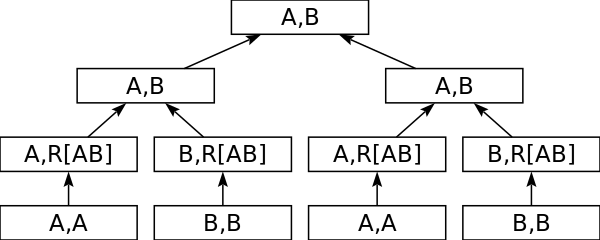

In [22]:
pAB = (Create "A" <||> Create "B") <> (Transmit "A" ("A", "R[AB]") <||> Transmit "B" ("B", "R[AB]")) <> Swap "R[AB]" ("A", "B")
pCR = ((Create "C" <> Transmit "C" ("C", "R[BC]")) <||> (Create "C" <> Transmit "C" ("C", "R[BC]"))) <> Distill ("C", "R[BC]")
pBC = (pCR <||> (Create "B" <> Transmit "B" ("B", "R[BC]"))) <> Swap "R[BC]" ("B", "C")

drawPolicy $ (((pAB <||> pAB) <> Distill ("A", "B"))) 

## Question

 * Show failures as part of the history? Could be too much of information?
 * Failures in distill and swap?
 * reachability in practice (only with some probability)
 * Simulating the actual run of the policy?
 * Generate the policy from probability